In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
file_path = "/kaggle/input/ptb-diagnostic-ecg-dataset/train_meta.csv" 
train_meta = pd.read_csv(file_path)
train_meta

,ecg_id,age,sex,height,weight,NORM,MI,STTC,HYP,CD
0,1,56.0,1,NaN,63.0,1,0,0,0,0
1,2,19.0,0,NaN,70.0,1,0,0,0,0
2,3,37.0,1,NaN,69.0,1,0,0,0,0
3,4,24.0,0,NaN,82.0,1,0,0,0,0
4,5,19.0,1,NaN,70.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,0,0,0,0,1
17437,21833,67.0,1,NaN,NaN,0,0,1,0,0
17438,21834,93.0,0,NaN,NaN,1,0,0,0,0
17439,21835,59.0,1,NaN,NaN,0,0,1,0,0


In [3]:
file_path = "/kaggle/input/ptb-diagnostic-ecg-dataset/train_signal.csv" 
train_signal = pd.read_csv(file_path)
train_signal

,ecg_id,channel-0,channel-1,channel-3
0,1,-0.119,-0.055,0.086
1,1,-0.116,-0.051,0.083
2,1,-0.120,-0.044,0.082
3,1,-0.117,-0.038,0.077
4,1,-0.103,-0.031,0.066
...,...,...,...,...
17440995,21836,0.096,0.189,-0.143
17440996,21836,0.051,0.119,-0.085
17440997,21836,0.033,0.070,-0.052
17440998,21836,0.027,0.082,-0.055


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_heart_rate(ecg_signal, sampling_rate=100):
    """
    Calculate heart rate from ECG signal using R-peak detection.
    """
    peaks, _ = find_peaks(ecg_signal, height=np.max(ecg_signal) * 0.85, distance=sampling_rate * 0.6 / 60)

    if len(peaks) < 2:
        return None, peaks  # Not enough peaks to calculate HR

    rr_intervals = np.diff(peaks) * (1 / sampling_rate)  # Convert sample differences to seconds
    heart_rate = 60 / np.mean(rr_intervals)

    return heart_rate, peaks

def calculate_sdnn(rr_intervals):
    return np.std(rr_intervals, ddof=1)  # Use ddof=1 for sample standard deviation

def calculate_rmssd(rr_intervals):
    rr_diff = np.diff(rr_intervals)  # Compute RR interval differences
    return np.sqrt(np.mean(rr_diff**2))  # RMSSD formula

def calculate_pnn50(rr_intervals):
    rr_diff = np.abs(np.diff(rr_intervals))  # Absolute differences
    count_pnn50 = np.sum(rr_diff > 0.05)  # Count differences > 50ms (0.05s)
    return (count_pnn50 / len(rr_diff)) * 100  # Percentage

def calculate_hrv_metrics(rr_intervals):
    sdnn = calculate_sdnn(rr_intervals)
    rmssd = calculate_rmssd(rr_intervals)
    pnn50 = calculate_pnn50(rr_intervals)
    return sdnn, rmssd, pnn50

def calculate_min_max_avg_hr(ecg_signal, sampling_rate=100, window_size=2):
    """
    Calculate min, max, and average heart rate over time windows.
    - `window_size` is in seconds (default: 2s)
    Returns:
      - avg_hr: Average HR over 10s
      - min_hr, min_time: Minimum HR with its time interval
      - max_hr, max_time: Maximum HR with its time interval
    """
    window_samples = window_size * sampling_rate
    heart_rates = []
    time_intervals = []
    rr_intervals_list = []

    for start in range(0, len(ecg_signal) - window_samples, window_samples):
        segment = ecg_signal[start : start + window_samples]
        hr, peaks = calculate_heart_rate(segment, sampling_rate)
        
        if hr and len(peaks) > 1:
            rr_intervals = np.diff(peaks) * (1 / sampling_rate)
            rr_intervals_list.extend(rr_intervals)
            heart_rates.append(hr)
            time_intervals.append((start / sampling_rate, (start + window_samples) / sampling_rate))  # (start_time, end_time)

    if not heart_rates:
        return None, None, None, None, None, None
    
    avg_hr = np.mean(heart_rates)
    min_idx = np.argmin(heart_rates)
    max_idx = np.argmax(heart_rates)
    
    # Calculate HRV Metrics
    if rr_intervals_list:
        sdnn, rmssd, pnn50 = calculate_hrv_metrics(rr_intervals_list)
    else:
        sdnn, rmssd, pnn50 = None, None, None
    
    return avg_hr, heart_rates[min_idx], time_intervals[min_idx], heart_rates[max_idx], time_intervals[max_idx], (sdnn, rmssd, pnn50)

def plot_ecg_on_grid(ecg_id, train_signal):
    """
    Plot full 10 seconds ECG signal on a standard ECG sheet.
    """
    ecg_data = train_signal[train_signal['ecg_id'] == ecg_id]

    if ecg_data.empty:
        print(f"No data found for ecg_id {ecg_id}")
        return

    channels = [col for col in ecg_data.columns if col != 'ecg_id']
    first_channel = channels[0]  # Only use the first channel for HR calculation
    signal = ecg_data[first_channel].values

    # Time axis: 1 data point = 0.01s
    time_axis = np.arange(len(signal)) * 0.01  

    # Calculate min, max, and avg HR over time intervals
    avg_hr, min_hr, min_time, max_hr, max_time, hrv_metrics = calculate_min_max_avg_hr(signal)
    
    # Plotting
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 8), sharex=True)

    if len(channels) == 1:
        axes = [axes]

    for ax, channel in zip(axes, channels):
        signal = ecg_data[channel].values

        # Adjust y-axis range dynamically
        y_min, y_max = np.min(signal) - 0.2, np.max(signal) + 0.2

        # Plot ECG signal
        ax.plot(time_axis, signal, color='black', linewidth=1)

        # Standard ECG Grid (1 mm = 0.04s, 0.1mV)
        ax.set_xticks(np.arange(0, 10, 0.04), minor=True)   # 1 mm (0.04s)
        ax.set_xticks(np.arange(0, 10, 0.2), minor=False)   # 5 mm (0.2s)
        ax.set_yticks(np.arange(y_min, y_max, 0.1), minor=True)  # 1 mm (0.1mV)
        ax.set_yticks(np.arange(y_min, y_max, 0.5), minor=False) # 5 mm (0.5mV)

        ax.grid(which='minor', color='red', linestyle=':', linewidth=0.5)  # Light grid (1 mm)
        ax.grid(which='major', color='red', linestyle='-', linewidth=1)    # Bold grid (5 mm)

        ax.set_ylim(y_min, y_max)
        ax.set_ylabel("mV")
        ax.set_title(f"ECG - {channel}")

    axes[-1].set_xlabel("Time (seconds)")
    plt.suptitle(f"ECG Signal for ID {ecg_id} on Standard ECG Grid")
    plt.tight_layout()
    plt.show()

    # Print heart rate and HRV details at the end
    if avg_hr and min_hr and max_hr and hrv_metrics:
        sdnn, rmssd, pnn50 = hrv_metrics
        print(f"Heart Rate for ECG ID {ecg_id}:")
        print(f"  - Average HR: {avg_hr:.1f} BPM")
        print(f"  - Minimum HR: {min_hr:.1f} BPM (Time: {min_time[0]:.2f}s - {min_time[1]:.2f}s)")
        print(f"  - Maximum HR: {max_hr:.1f} BPM (Time: {max_time[0]:.2f}s - {max_time[1]:.2f}s)")
        print(f"HRV Metrics:")
        print(f"  - SDNN: {sdnn:.2f} ms")
        print(f"  - RMSSD: {rmssd:.2f} ms")
        print(f"  - pNN50: {pnn50:.2f} %")
    else:
        print(f"Could not determine heart rate or HRV for ECG ID {ecg_id}.")


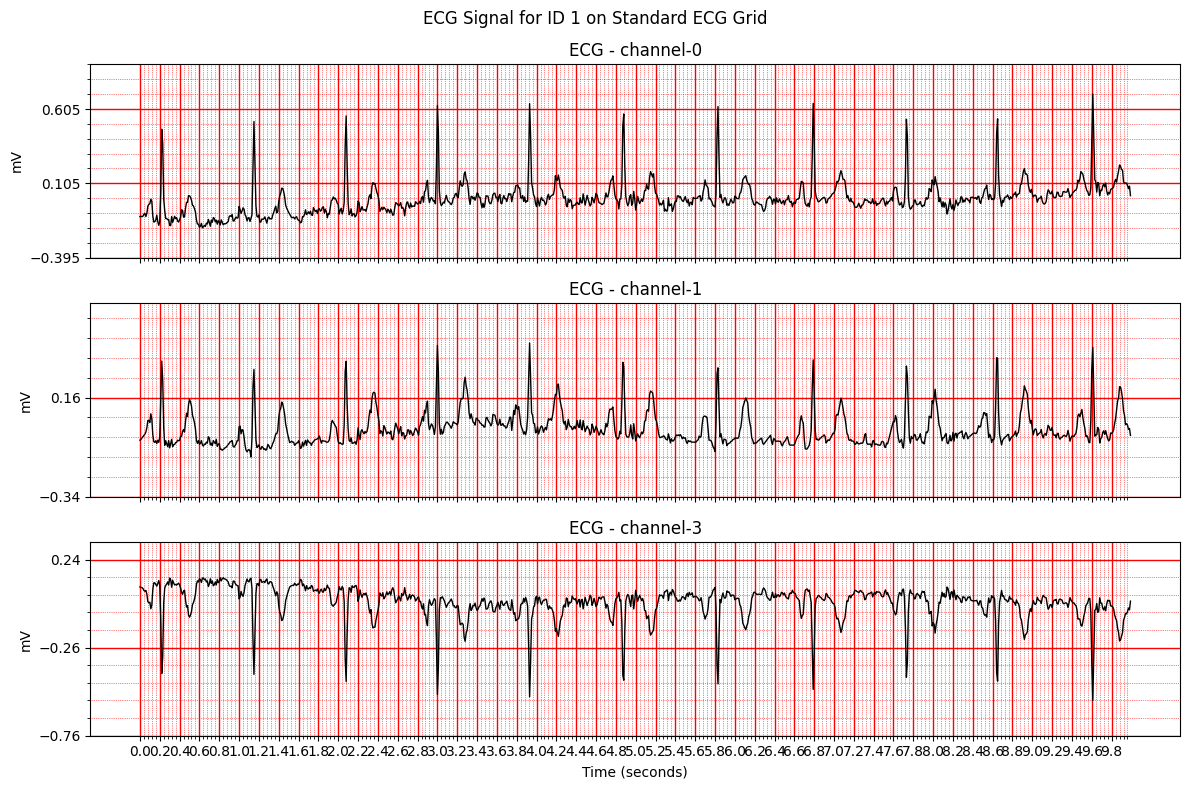

Heart Rate for ECG ID 1:
  - Average HR: 64.2 BPM
  - Minimum HR: 63.2 BPM (Time: 4.00s - 6.00s)
  - Maximum HR: 64.9 BPM (Time: 2.00s - 4.00s)
HRV Metrics:
  - SDNN: 0.01 ms
  - RMSSD: 0.01 ms
  - pNN50: 0.00 %


In [5]:
plot_ecg_on_grid(ecg_id=1, train_signal=train_signal)

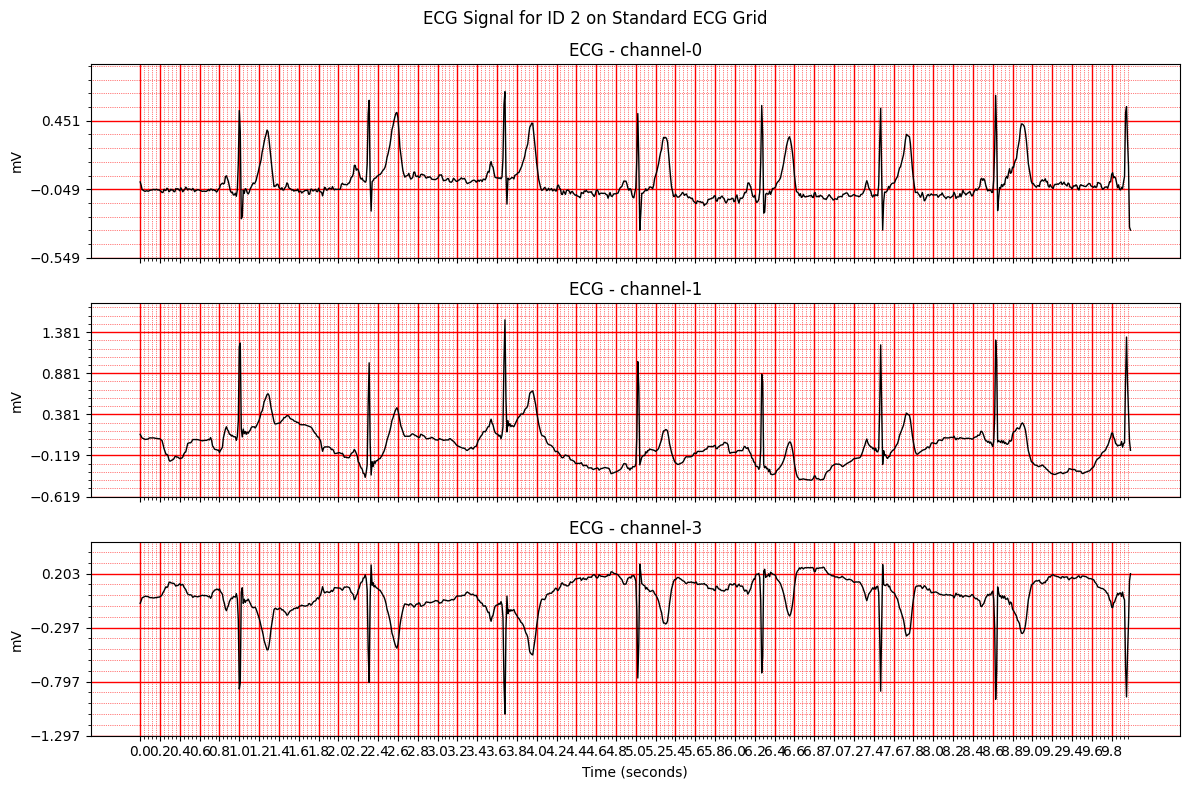

Heart Rate for ECG ID 2:
  - Average HR: 46.9 BPM
  - Minimum HR: 43.8 BPM (Time: 2.00s - 4.00s)
  - Maximum HR: 50.0 BPM (Time: 6.00s - 8.00s)
HRV Metrics:
  - SDNN: 0.12 ms
  - RMSSD: 0.17 ms
  - pNN50: 100.00 %


In [6]:
plot_ecg_on_grid(ecg_id=2, train_signal=train_signal)

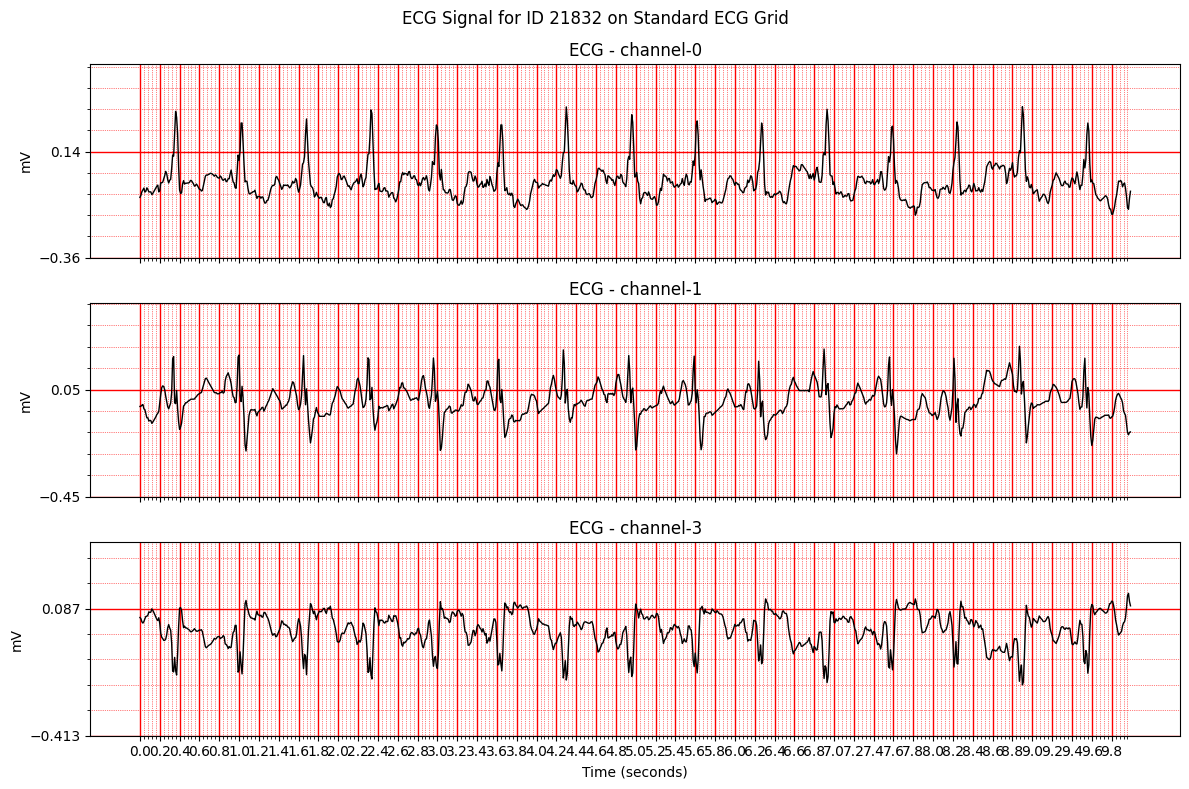

Heart Rate for ECG ID 21832:
  - Average HR: 68.2 BPM
  - Minimum HR: 45.5 BPM (Time: 0.00s - 2.00s)
  - Maximum HR: 90.9 BPM (Time: 4.00s - 6.00s)
HRV Metrics:
  - SDNN: 0.47 ms
  - RMSSD: 0.66 ms
  - pNN50: 100.00 %


In [7]:
plot_ecg_on_grid(ecg_id=21832, train_signal=train_signal)

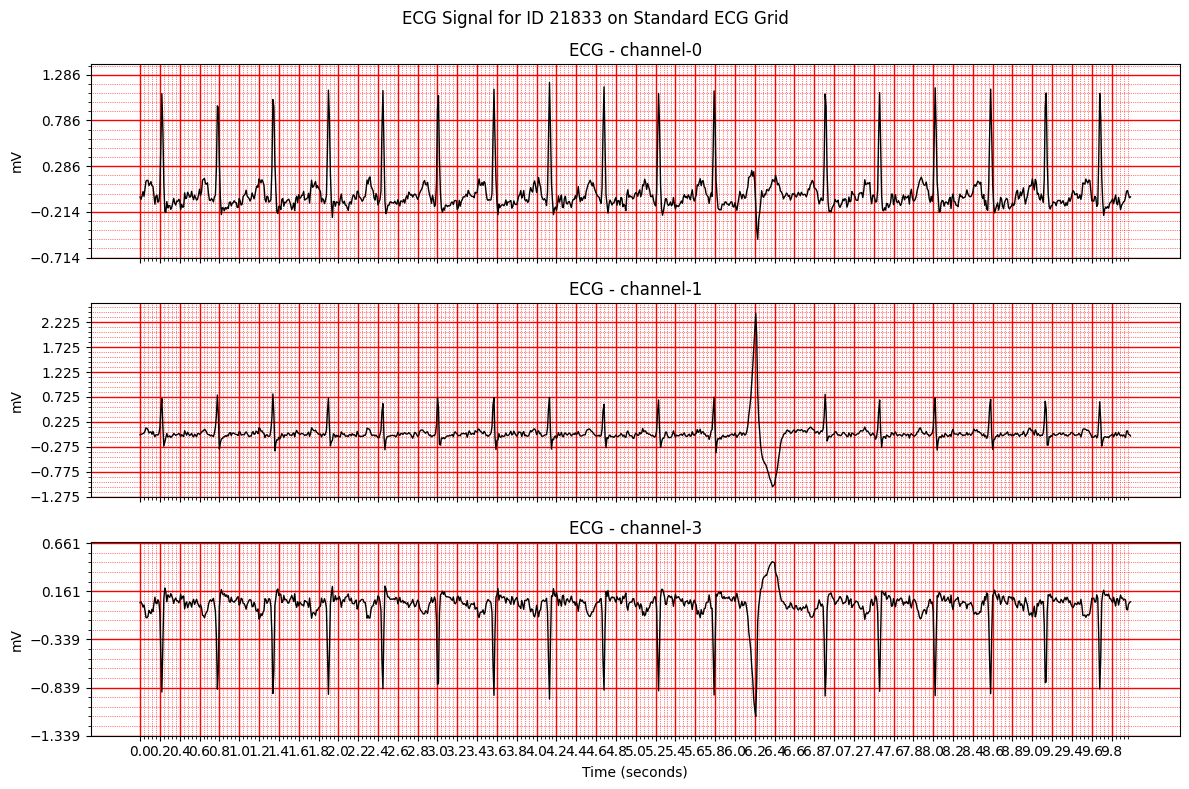

Heart Rate for ECG ID 21833:
  - Average HR: 99.0 BPM
  - Minimum HR: 71.4 BPM (Time: 0.00s - 2.00s)
  - Maximum HR: 109.1 BPM (Time: 6.00s - 8.00s)
HRV Metrics:
  - SDNN: 0.20 ms
  - RMSSD: 0.21 ms
  - pNN50: 14.29 %


In [8]:
plot_ecg_on_grid(ecg_id=21833, train_signal=train_signal)

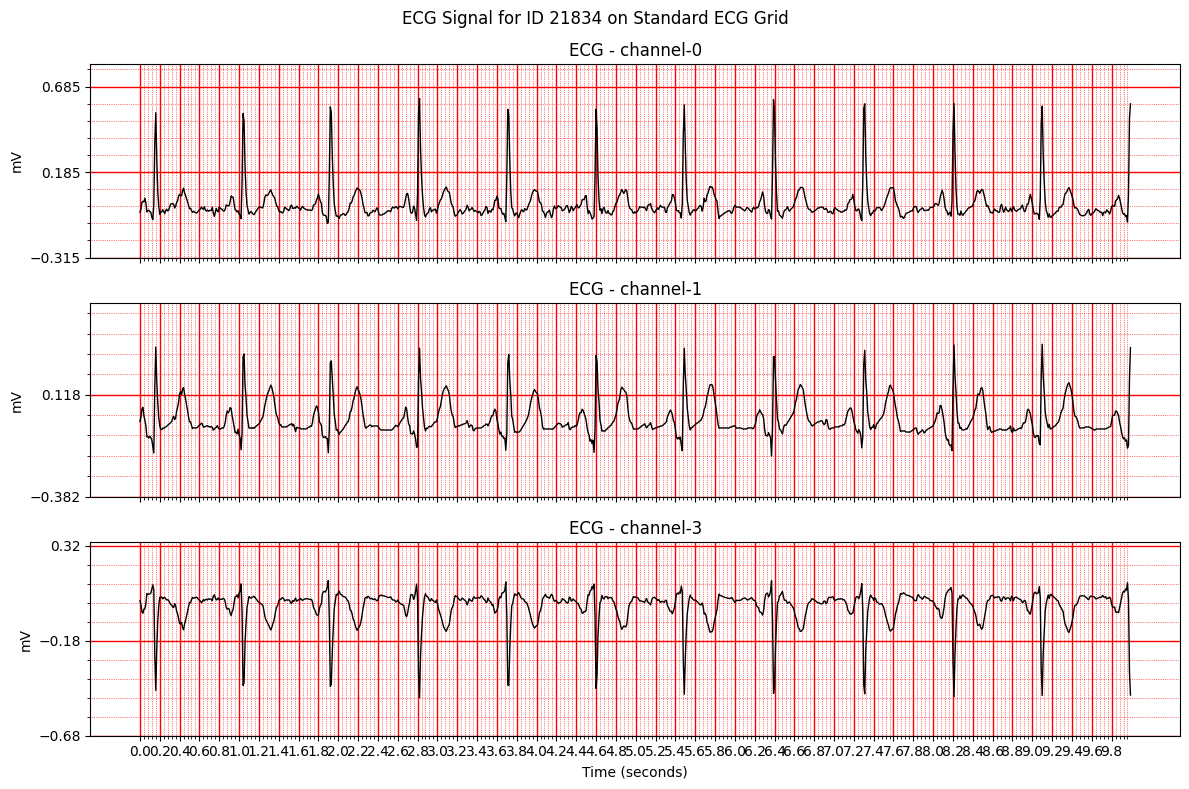

Heart Rate for ECG ID 21834:
  - Average HR: 67.1 BPM
  - Minimum HR: 65.2 BPM (Time: 6.00s - 8.00s)
  - Maximum HR: 68.2 BPM (Time: 0.00s - 2.00s)
HRV Metrics:
  - SDNN: 0.02 ms
  - RMSSD: 0.02 ms
  - pNN50: 0.00 %


In [9]:
plot_ecg_on_grid(ecg_id=21834, train_signal=train_signal)

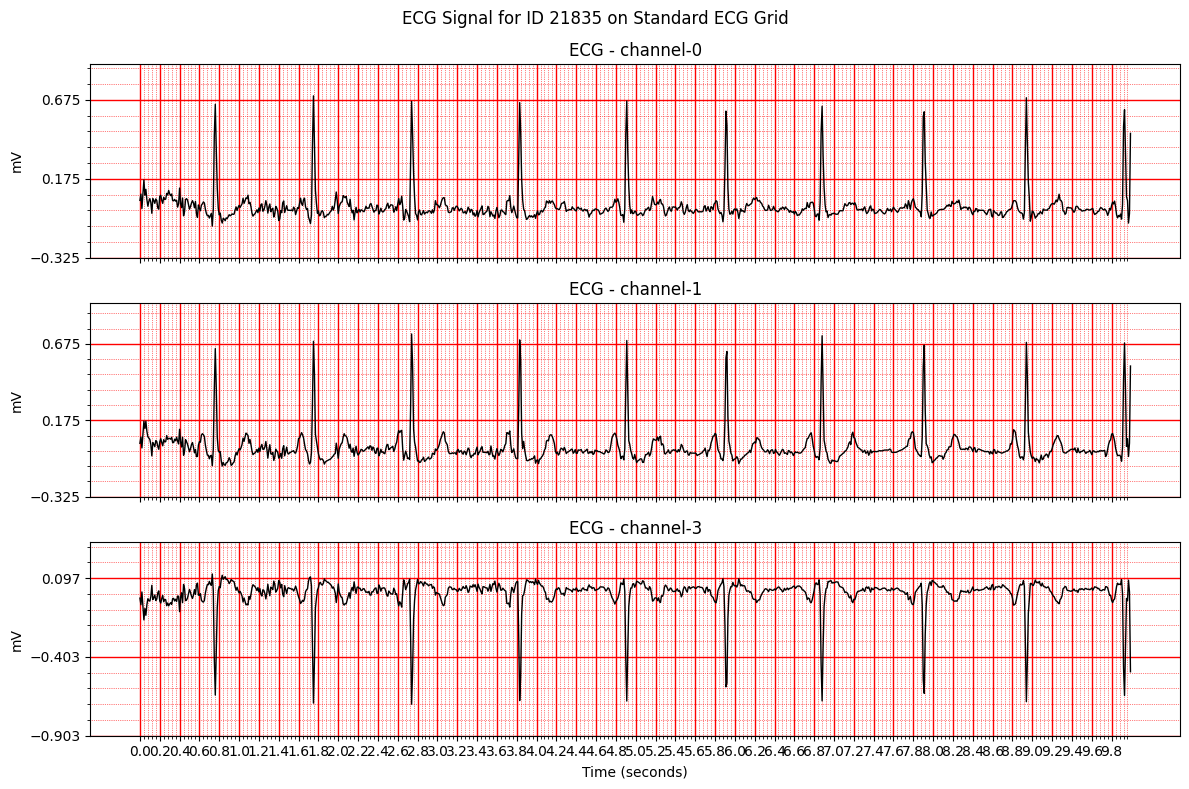

Heart Rate for ECG ID 21835:
  - Average HR: 58.5 BPM
  - Minimum HR: 55.0 BPM (Time: 2.00s - 4.00s)
  - Maximum HR: 60.6 BPM (Time: 0.00s - 2.00s)
HRV Metrics:
  - SDNN: 0.05 ms
  - RMSSD: 0.08 ms
  - pNN50: 66.67 %


In [10]:
plot_ecg_on_grid(ecg_id=21835, train_signal=train_signal)